In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import lime
import lime.lime_tabular
import shap
import time
import sys
sys.path.append('../../wrapper')
import xgboost
import random

import mglearn
import sklearn
import sklearn.datasets

from sklearn import preprocessing, pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel, SelectPercentile

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, cohen_kappa_score
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

import matplotlib
import matplotlib.pyplot as plt

In [2]:
class Timer(object):
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()

    def __exit__(self, type, value, traceback):
        if self.name:
            print ('[%s]' % self.name)
        print ('Elapsed: %s' % (time.time() - self.tstart))

In [3]:
R = np.random.RandomState(0)
df = pd.DataFrame(R.randint(low=1, high=11, size=(10000, 1)), columns=['a'])
df['b'] = R.randint(low=1, high=11, size=(10000, 1))
df['c'] = R.randint(low=1, high=11, size=(10000, 1))
df['d'] = R.randint(low=1, high=11, size=(10000, 1))

df['a*b'] = df.a * df.b
df['a/b'] = df.a / df.b
#df['a*b*c'] = df.a * df.b * df.c

#df['y'] = np.where((df['a*b'] > 60)  , 'True', 'False')
#df['y'] = np.where((df['a*b'] > 60) & (df['b'] > 9) , 'True', 'False')
df['y'] = np.where((df['a*b'] > 55) & (df['c'] > 7) & (df['d'] < 7), 'True', 'False')

for i in range(500):
    df[i+1] = R.randint(low=1, high=11, size=(10000, 1))
#df.plot.box()

In [4]:
df.describe()

,a,b,c,d,a*b,a/b,1,2,3,4,...,491,492,493,494,495,496,497,498,499,500
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.539700,5.445900,5.499000,5.505500,30.08080,1.644557,5.471700,5.526700,5.480800,5.494900,...,5.525200,5.502400,5.456700,5.575500,5.500300,5.474400,5.510800,5.478300,5.514800,5.502400
std,2.885525,2.861904,2.860283,2.847662,23.62931,1.864735,2.848896,2.875189,2.884417,2.887318,...,2.894789,2.859932,2.857926,2.868226,2.869325,2.858314,2.890591,2.895923,2.876944,2.866429
min,1.000000,1.000000,1.000000,1.000000,1.00000,0.100000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000,10.00000,0.555556,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,6.000000,5.000000,5.000000,5.000000,24.00000,1.000000,6.000000,6.000000,5.000000,5.000000,...,6.000000,6.000000,5.000000,6.000000,5.000000,5.000000,5.000000,5.000000,6.000000,6.000000
75%,8.000000,8.000000,8.000000,8.000000,45.00000,2.000000,8.000000,8.000000,8.000000,8.000000,...,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
max,10.000000,10.000000,10.000000,10.000000,100.00000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [5]:
df.groupby('y').count()

,a,b,c,d,a*b,a/b,1,2,3,4,...,491,492,493,494,495,496,497,498,499,500
y,,,,,,,,,,,,,,,,,,,,,
False,9686,9686,9686,9686,9686,9686,9686,9686,9686,9686,...,9686,9686,9686,9686,9686,9686,9686,9686,9686,9686
True,314,314,314,314,314,314,314,314,314,314,...,314,314,314,314,314,314,314,314,314,314


In [6]:
y = df.y
X = df.drop(['y'], 1)
feature_names = df.drop(['y'], 1).columns.values.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [7]:
le= sklearn.preprocessing.LabelEncoder()
le.fit(y)
labels = le.transform(y)
class_names = le.classes_
target_names = np.array(le.classes_)

In [8]:
rf = RandomForestClassifier(n_estimators=500, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [10]:
sklearn.metrics.accuracy_score(y_test, rf.predict(X_test))
print('Train score: {:.4f}'.format(rf.score(X_train, y_train)))
print('Test score: {:.4f}'.format(rf.score(X_test, y_test)))

Train score: 1.0000
Test score: 0.9760


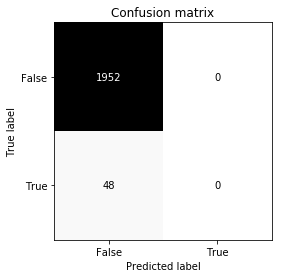

In [11]:
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test, rf.predict(X_test)), xlabel='Predicted label',
    ylabel='True label', xticklabels=target_names,
    yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

### Random under-sampling

In [12]:
print('y_resample:\n{}'.format(pd.Series(y_train).value_counts()))

y_resample:
False    7734
True      266
Name: y, dtype: int64


In [9]:
rus = RandomUnderSampler(random_state=0)
X_train_sampled, y_train_sampled = rus.fit_sample(X_train, y_train)
print('X_resampled.shape: {}, y_resampled: {}'.format(X_train_sampled.shape, y_train_sampled.shape))
print('y_resample:\n{}'.format(pd.Series(y_train_sampled).value_counts()))

X_resampled.shape: (532, 506), y_resampled: (532,)
y_resample:
True     266
False    266
dtype: int64


In [14]:
rf.fit(X_train_sampled, y_train_sampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [15]:
sklearn.metrics.accuracy_score(y_test, rf.predict(X_test))
print('Train score: {:.4f}'.format(rf.score(X_train_sampled, y_train_sampled)))
print('Test score: {:.4f}'.format(rf.score(X_test, y_test)))

Train score: 1.0000
Test score: 0.9245


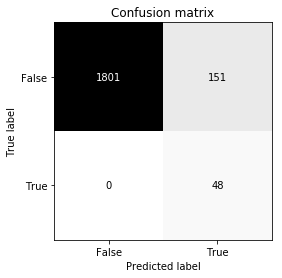

In [16]:
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test, rf.predict(X_test)), xlabel='Predicted label',
    ylabel='True label', xticklabels=target_names,
    yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

In [10]:
X_train_sampled = pd.DataFrame(X_train_sampled, columns=list(X_train))

### Feature selection

In [11]:
select = SelectFromModel(
    RandomForestClassifier(n_estimators=500, random_state=0),
    threshold="2.1*median")
#    threshold="6.7*median")

In [12]:
select.fit(X_train_sampled, y_train_sampled)
#X_train_selected = select.transform(X_train_sampled)
idxs_selected = select.get_support(indices=True)
X_train_selected = X_train_sampled.iloc[:, idxs_selected]

#X_test_selected = select.transform(X_test_sampled)
#idxs_selected = select.get_support(indices=True)
X_test_selected = X_test.iloc[:, idxs_selected]

print("X_train.shape: {}".format(X_train_sampled.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))
print("X_test_selected.shape: {}".format(X_test_selected.shape))

X_train.shape: (532, 506)
X_train_selected.shape: (532, 14)
X_test_selected.shape: (2000, 14)


In [20]:
feature_importances = select.estimator_.feature_importances_[idxs_selected]
idx = sorted(range(len(feature_importances)), key=lambda k: feature_importances[k])

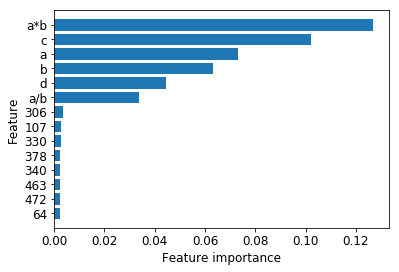

In [21]:
plt.rcParams['savefig.dpi'] = 120 # Use 300 for PDF, 100 for slides
def plot_feature_importances(model):
    n_features = X_train_selected.shape[1]
    plt.barh(range(n_features), sorted(feature_importances), align='center')
    plt.yticks(np.arange(n_features), np.array(list(X_train_selected))[idx])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

    
plt.rcParams.update({'font.size': 12})
plot_feature_importances(select)

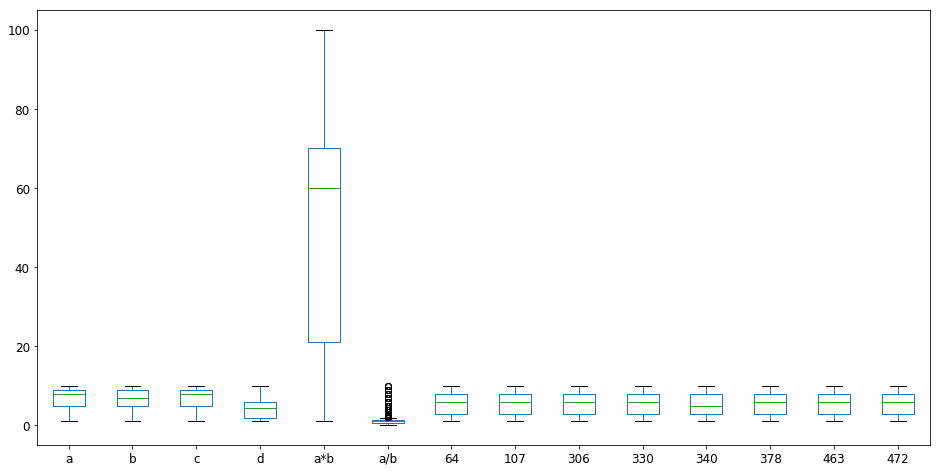

In [22]:
X_train_selected.plot.box(figsize=(16,8))

In [13]:
def classification(classifier):
    model = classifier
    model.fit(X_train_selected, y_train_sampled)
    cv_score = np.mean(cross_val_score(model, X_train_selected, y_train_sampled, cv=5))
    test_score = model.score(X_test_selected, y_test)
    print('Classifier parameters:', model.get_params)
    print("Cross-validation accuracy: {:.3f}".format(cv_score))    
    print('Test score: {:.3f}'.format(test_score))
    return model, cv_score, test_score

In [14]:
def confusion_matrix_plot(X_valid, y_valid, clf):
    plt.rcParams.update({'font.size': 16})
    plt.rcParams.update({'axes.titlesize': 16})
    plt.rcParams.update({'axes.labelsize': 16})
    plt.rcParams.update({'ytick.labelsize': 16})
    plt.rcParams.update({'xtick.labelsize': 16})
    f, ax = plt.subplots(figsize=(6, 6))
    target_names = ['Not Mo1', 'Mo1']
    scores_image = mglearn.tools.heatmap(
        confusion_matrix(y_valid, le.transform(clf.predict(X_valid))), xlabel='Predicted label',
        ylabel='True label', xticklabels=target_names,
        yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
    plt.title("Confusion matrix")
    plt.gca().invert_yaxis()

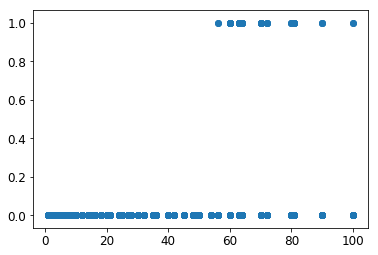

In [25]:
plt.scatter(X_test_selected["a*b"], le.transform(y_test))

In [233]:
pipe = pipeline.Pipeline([('preprocessing', None), ('classifier', SVC())])
param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), MinMaxScaler(), None],
     'classifier__kernel': ['rbf', 'linear'],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
#     {'classifier': [RandomForestClassifier()], 'preprocessing': [StandardScaler(), None],
#      'classifier__n_estimators': [100, 500, 1000],
#      'classifier__bootstrap': [True, False],
#      'classifier__criterion': ['gini', 'entropy']},
]
     
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)

grid.fit(X_train_selected, y_train_sampled)
print("Best cross-validation accuracy: {:.3f}".format(grid.best_score_))
print("Test set score: {:.3f}".format(grid.score(X_test_selected, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.998
Test set score: 0.991
Best parameters: {'preprocessing': None, 'classifier__kernel': 'linear', 'classifier': SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__gamma': 0.001, 'classifier__C': 1}


In [25]:
svm_1, cv_score_svm_1, test_score_svm_1 = classification(SVC(gamma=10, probability=True))
svm_2, cv_score_svm_2, test_score_svm_2 = classification(SVC(gamma=1, probability=True))
svm_3, cv_score_svm_3, test_score_svm_3 = classification(SVC(gamma=0.1, probability=True))
svm_4, cv_score_svm_4, test_score_svm_4 = classification(SVC(gamma=0.01, probability=True))

Classifier parameters: <bound method BaseEstimator.get_params of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)>
Cross-validation accuracy: 0.681
Test score: 0.463
Classifier parameters: <bound method BaseEstimator.get_params of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)>
Cross-validation accuracy: 0.504
Test score: 0.976
Classifier parameters: <bound method BaseEstimator.get_params of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)>
Cross-validation accuracy: 0.713
Test sc

Classifier parameters: <bound method BaseEstimator.get_params of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)>
Cross-validation accuracy: 0.504
Test score: 0.976
AUC score: 0.500
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      1952
          1       0.00      0.00      0.00        48

avg / total       0.95      0.98      0.96      2000

None


/Users/lillian/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Classifier parameters: <bound method BaseEstimator.get_params of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)>
Cross-validation accuracy: 0.713
Test score: 0.974
AUC score: 0.763
             precision    recall  f1-score   support

          0       0.99      0.98      0.99      1952
          1       0.46      0.54      0.50        48

avg / total       0.98      0.97      0.97      2000

None
Classifier parameters: <bound method BaseEstimator.get_params of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)>
Cross-validation accuracy: 0.951
Test score: 0.938
AUC score: 0.968
             precision    recall  f1-score   support

          0    

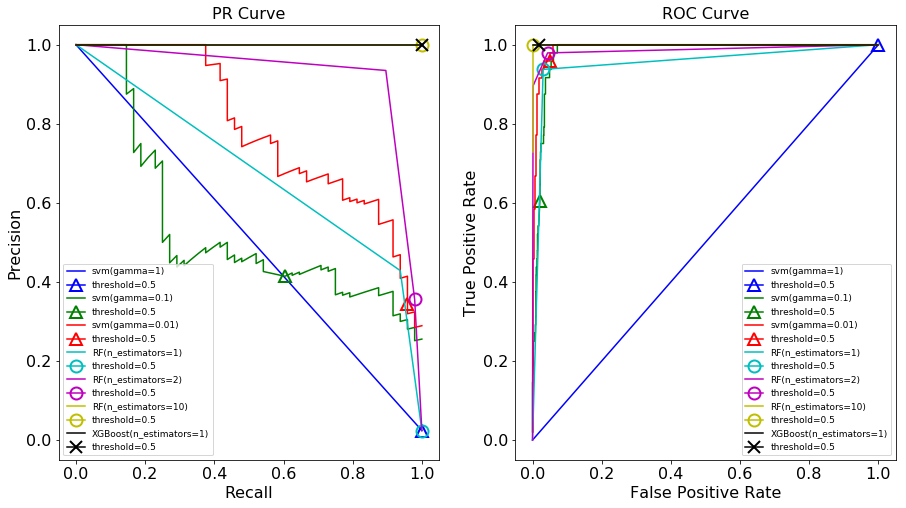

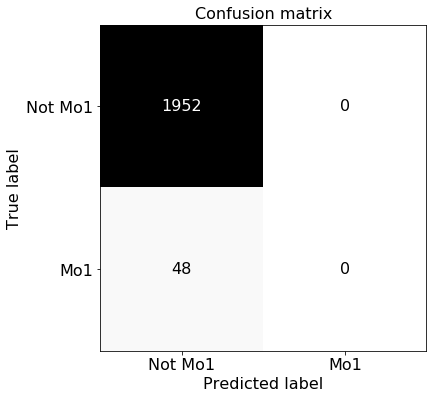

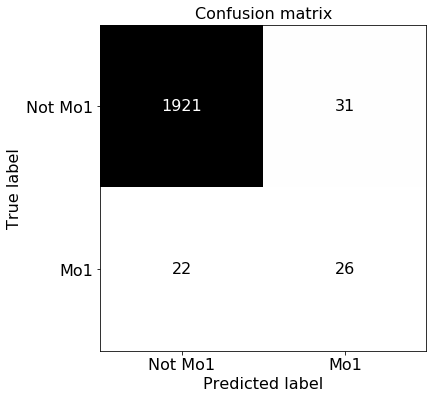

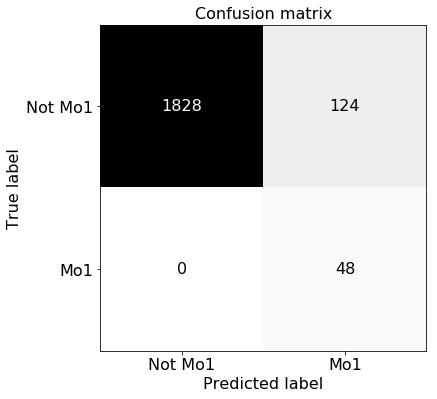

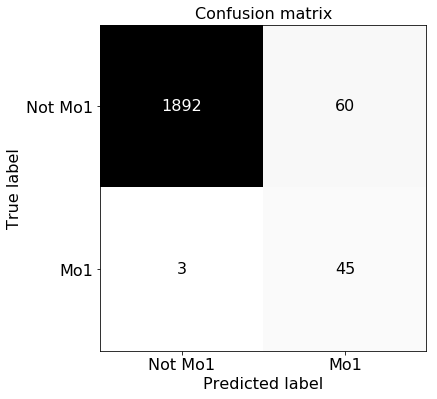

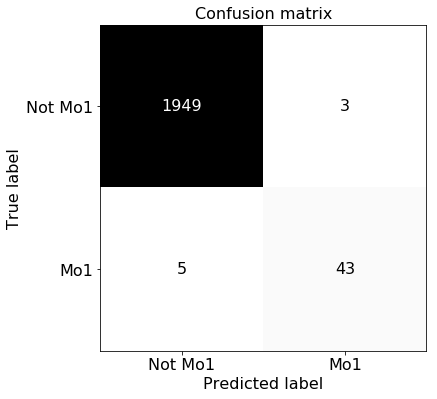

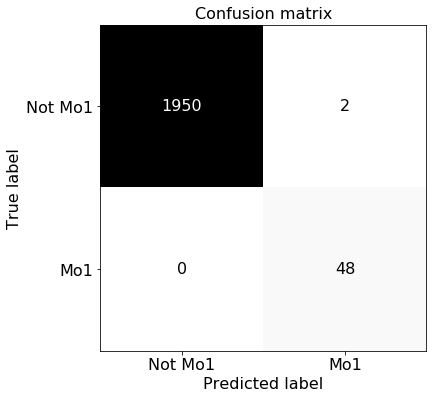

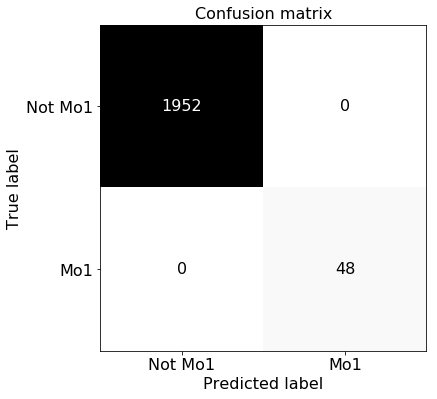

In [84]:
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')


label = le.transform(y_test)
### SVMs
for par, k in zip([1, 0.1, 0.01], 'bgrcmykw'):
    clf, _, _= classification(SVC(gamma=par, probability=True))
    pred = le.transform(clf.predict(X_test_selected))

    print("AUC score: {:.3f}".format(roc_auc_score(label, pred)))
    print(classification_report(label, pred))
    print(confusion_matrix_plot(X_test_selected, label, clf))
    pred_prob = clf.predict_proba(X_test_selected)[:,1]
    
    precision, recall, thresholds_pr = precision_recall_curve(label, pred_prob)
    fpr, tpr, thresholds_roc = roc_curve(label, pred_prob)

    ax1.plot(recall, precision, c=k, label=par)
    ax2.plot(fpr, tpr, c=k, label=par)
    
    close_default_pr = np.argmin(np.abs(thresholds_pr - 0.5))
    close_default_roc = np.argmin(np.abs(thresholds_roc - 0.5))

    ax1.plot(recall[close_default_pr], precision[close_default_pr], marker='^', markersize=12,
             fillstyle="none", c=k, mew=2)#, label=par)
    ax2.plot(fpr[close_default_roc], tpr[close_default_roc], marker='^', markersize=12,
             fillstyle="none", c=k, mew=2, label=par)
#     print(fpr, tpr, precision, recall, thresholds_pr)


### Random forests    
for par, k in zip([1, 2, 10], 'cmykw'):
    clf, _, _=     classification(RandomForestClassifier(n_estimators=par, random_state=0))
    pred = le.transform(clf.predict(X_test_selected))

    print("AUC score: {:.3f}".format(roc_auc_score(label, pred)))
    print(classification_report(label, pred))
    print(confusion_matrix_plot(X_test_selected, label, clf))
    pred_prob = clf.predict_proba(X_test_selected)[:,1]
    
    precision, recall, thresholds_pr = precision_recall_curve(label, pred_prob)
    fpr, tpr, thresholds_roc = roc_curve(label, pred_prob)
#     print(precision, recall, thresholds_roc)
    ax1.plot(recall, precision, c=k, label=par)
    ax2.plot(fpr, tpr, c=k, label=par)
    
    close_default_pr = np.argmin(np.abs(thresholds_pr - 0.5))
    close_default_roc = np.argmin(np.abs(thresholds_roc - 0.5))
#     close_default_pr = np.argmin(np.abs(thresholds_pr - 1.0))
#     close_default_roc = np.argmin(np.abs(thresholds_roc - 1.0))

    ax1.plot(recall[close_default_pr], precision[close_default_pr], marker='o', markersize=12,
             fillstyle="none", c=k, mew=2)#, label=par)
    ax2.plot(fpr[close_default_roc], tpr[close_default_roc], marker='o', markersize=12,
             fillstyle="none", c=k, mew=2, label=par)    
    print(fpr, tpr, fpr[close_default_roc], tpr[close_default_roc], precision, recall, recall[close_default_pr], precision[close_default_pr], thresholds_pr)
    print('t1', np.abs(thresholds_roc - 0.5), thresholds_roc, close_default_roc)
    print('t2', np.abs(thresholds_pr - 0.5), thresholds_pr, close_default_pr)


### XGBoost    
clf, _, _= classification(XGBClassifier(n_estimators=1, random_state=0))
pred = le.transform(clf.predict(X_test_selected))

print("AUC score: {:.3f}".format(roc_auc_score(label, pred)))
print(classification_report(label, pred))
print(confusion_matrix_plot(X_test_selected, label, clf))
pred_prob = clf.predict_proba(X_test_selected)[:,1]
    
precision, recall, thresholds_pr = precision_recall_curve(label, pred_prob)
fpr, tpr, thresholds_roc = roc_curve(label, pred_prob)
#     print(precision, recall, thresholds_roc)
ax1.plot(recall, precision, c='k', label=par)
ax2.plot(fpr, tpr, c='k', label=par)
    
close_default_pr = np.argmin(np.abs(thresholds_pr - 0.5))
close_default_roc = np.argmin(np.abs(thresholds_roc - 0.5))
ax1.plot(recall[close_default_pr], precision[close_default_pr], marker='x', markersize=12, 
         fillstyle="none", c='k', mew=2)#, label=par)
ax2.plot(fpr[close_default_roc], tpr[close_default_roc], marker='x', markersize=12,
         fillstyle="none", c='k', mew=2)#, label=par)      
    
# ax1.legend()
ax1.legend(labels=['svm(gamma=1)', 'threshold=0.5', 'svm(gamma=0.1)', 
                   'threshold=0.5', 'svm(gamma=0.01)', 'threshold=0.5',
                  'RF(n_estimators=1)', 'threshold=0.5', 'RF(n_estimators=2)', 
                   'threshold=0.5', 'RF(n_estimators=10)', 'threshold=0.5',
                  'XGBoost(n_estimators=1)', 'threshold=0.5'], loc='lower left', prop={'size': 9})    
ax2.legend(labels=['svm(gamma=1)', 'threshold=0.5', 'svm(gamma=0.1)', 
                   'threshold=0.5', 'svm(gamma=0.01)', 'threshold=0.5',
                  'RF(n_estimators=1)', 'threshold=0.5', 'RF(n_estimators=2)', 
                   'threshold=0.5', 'RF(n_estimators=10)', 'threshold=0.5',
                  'XGBoost(n_estimators=1)', 'threshold=0.5'], loc='lower right', prop={'size': 9}) 
# ax2.legend(legend_elements2, labels=['svm_(gamma=1)', 'svm_(gamma=0.1)', 'svm_(gamma=0.01)'], loc='lower right')
plt.show()

Classifier parameters: <bound method BaseEstimator.get_params of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)>
Cross-validation accuracy: 0.504
Test score: 0.976
Classifier parameters: <bound method BaseEstimator.get_params of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)>
Cross-validation accuracy: 0.713
Test score: 0.974
Classifier parameters: <bound method BaseEstimator.get_params of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)>
Cross-validation accuracy: 0.951
Test score: 0.

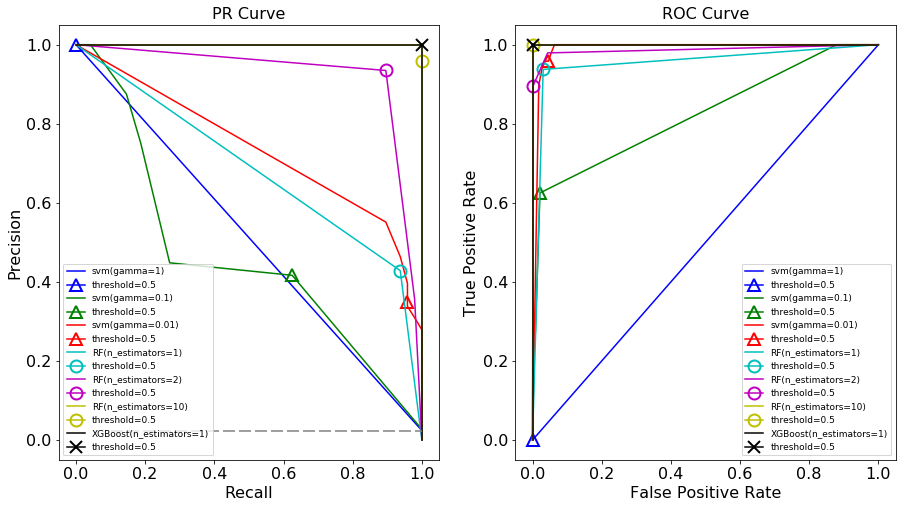

In [140]:
import matplotlib.pyplot as plt
import numpy as np

# score = np.array([0.9, 0.8, 0.7, 0.6, 0.55, 0.54, 0.53, 0.52, 0.51, 0.505, 0.4, 0.39, 0.38, 0.37, 0.36, 0.35, 0.34, 0.33, 0.30, 0.1])
# y = np.array([1,1,0, 1, 1, 1, 0, 0, 1, 0, 1,0, 1, 0, 0, 0, 1 , 0, 1, 0])
y = le.transform(y_test)
# for par, k in zip([1, 0.1, 0.01], 'bgrcmykw'):
# clf, _, _= classification(SVC(gamma=0.1, probability=True))
# score = clf.predict_proba(X_test_selected)[:,1]

def safe_div(x,y):
    if y == 0:
        return 0
    return x / y

def plot_roc_curve(clf, score, y, color, mark):
    pr_x = []
    pr_y = []
    
    roc_x = []
    roc_y = []
    min_score = min(score)
    max_score = max(score)
    # thr = np.linspace(min_score, max_score, 30)
    thr = np.linspace(0.1, 1.0, 10)
#     print(thr)
    FP=0
    TP=0
    P = sum(y)
    N = len(y) - P
    pr_x.append(1)
    pr_y.append(0)
    roc_x.append(1)
    roc_y.append(1)
    for (i, T) in enumerate(thr):
        for i in range(0, len(score)):
            if (score[i] > T):
                if (y[i]==1):
                    TP = TP + 1
                if (y[i]==0):
                    FP = FP + 1

        pr_x.append(safe_div(TP, P))
        if (safe_div(TP, float(P)) == 0):
            pr_y.append(1) 
        else:
            pr_y.append(safe_div(TP, (TP+FP)))

        roc_x.append(safe_div(FP, N))
        roc_y.append(safe_div(TP, P))
#         print(T, TP, FP, float(TP+FP), pr_x, pr_y)
#         print(T, TP, float(P), TP/float(P), roc_y)    

        FP=0
        TP=0
    if (np.min(pr_x) !=0):
        pr_x.append(0)
        pr_y.append(1)

    ax1.plot(pr_x, pr_y, c=color)

    ax2.plot(roc_x, roc_y, c=color)
    
#     ax1.scatter(pr_x, pr_y, c=color)
#     ax2.scatter(roc_x, roc_y, c=color)
    
    for (i, T) in enumerate(thr):   
#         print(i, T, thr)
        if (T==0.5):
#             print('test', i)
#             ax1.text(pr_x[i], pr_y[i], thr[i], fontsize=12, color=color)
#             ax2.text(roc_x[i], roc_y[i], thr[i], fontsize=12, color=color)
            ax1.plot(pr_x[i+1], pr_y[i+1], marker=mark, markersize=12, 
                     fillstyle="none", mew=2, c=color)#, label=par)
            ax2.plot(roc_x[i+1], roc_y[i+1], marker=mark, markersize=12,
                     fillstyle="none", mew=2, c=color)
#         print('pr', pr_x[i], pr_y[i], thr[i])
#         print('roc', roc_x[i], roc_y[i], thr[i])

    return ax1, ax2

    
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for par, k in zip([1, 0.1, 0.01], 'bgr'):
    clf, _, _=  classification(SVC(gamma=par, probability=True, random_state=0))
    score = clf.predict_proba(X_test_selected)[:,1]
    plot_roc_curve(clf, score, y, k, '^')
    
for par, k in zip([1, 2, 10], 'cmy'):
    clf, _, _=  classification(RandomForestClassifier(n_estimators=par, random_state=0))    
    score = clf.predict_proba(X_test_selected)[:,1]
    plot_roc_curve(clf, score, y, k, 'o')
    
clf, _, _=  classification(XGBClassifier(n_estimators=1, random_state=0))    
score = clf.predict_proba(X_test_selected)[:,1]
plot_roc_curve(clf, score, y, 'k', 'x')    

P = sum(y)
N = len(y) - P
ax1.plot(np.linspace(0.1, 1.0, 10), np.repeat(P/(P+N), 10), c='grey', dashes=[6, 2])

thres_mark = 0.5
ax1.legend(labels=['svm(gamma=1)', 'threshold='+str(thres_mark), 'svm(gamma=0.1)', 
                   'threshold='+str(thres_mark), 'svm(gamma=0.01)', 'threshold='+str(thres_mark),
                  'RF(n_estimators=1)', 'threshold='+str(thres_mark), 'RF(n_estimators=2)', 
                   'threshold='+str(thres_mark), 'RF(n_estimators=10)', 'threshold='+str(thres_mark),
                  'XGBoost(n_estimators=1)', 'threshold='+str(thres_mark)], loc='lower left', prop={'size': 9})    
ax2.legend(labels=['svm(gamma=1)', 'threshold='+str(thres_mark), 'svm(gamma=0.1)', 
                   'threshold='+str(thres_mark), 'svm(gamma=0.01)', 'threshold='+str(thres_mark),
                  'RF(n_estimators=1)', 'threshold='+str(thres_mark), 'RF(n_estimators=2)', 
                   'threshold='+str(thres_mark), 'RF(n_estimators=10)', 'threshold='+str(thres_mark),
                  'XGBoost(n_estimators=1)', 'threshold='+str(thres_mark)], loc='lower right', prop={'size': 9}) 
plt.show()

In [83]:
### i = 0
tpr = []
fpr = []
acc = []
y_test_num = le.transform(y_test)
for gamma in [1]:
    for thres in [i/30 for i in range(30)]:
        svc = SVC(gamma=gamma, probability=True).fit(X_train_selected, y_train_sampled)
        prob = svc.predict_proba(X_test_selected)
        lable = np.where((prob[:, 1] >= thres)  , 1, 0)
        tpr.append([sum((lable == y_test_num) & (lable == 1)) / sum(y_test_num == 1) if sum(y_test_num == 1)!= 0 else 0])
        fpr.append([sum((lable != y_test_num) & (lable == 1)) / sum(y_test_num == 0) if sum(y_test_num == 0)!= 0 else 0])
        acc.append(sum(y_test_num == lable)/len(lable))
        
        i = i+1

[<matplotlib.lines.Line2D at 0x117a8c1d0>]

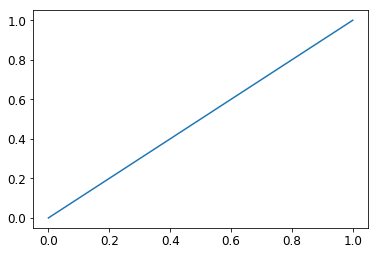

In [253]:
plt.plot(fpr, tpr)

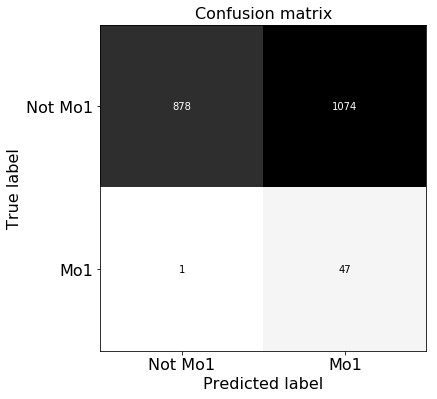

In [65]:
confusion_matrix_plot(X_test_selected, y_test, svm_1)

In [75]:
evaluate_scores(X_test_selected, y_test, svm_1)


AUC score: 0.714
Accuracy score: 0.463
F1-micro score: 0.463
Cohen kappa score: 0.036
             precision    recall  f1-score   support

          0       1.00      0.45      0.62      1952
          1       0.04      0.98      0.08        48

avg / total       0.98      0.46      0.61      2000



In [63]:
def confusion_matrix_plot(X_valid, y_valid, clf):
    plt.rcParams.update({'axes.titlesize': 16})
    plt.rcParams.update({'axes.labelsize': 16})
    plt.rcParams.update({'ytick.labelsize': 16})
    plt.rcParams.update({'xtick.labelsize': 16})
    f, ax = plt.subplots(figsize=(6, 6))
    target_names = ['Not Mo1', 'Mo1']
    scores_image = mglearn.tools.heatmap(
        confusion_matrix(y_valid, clf.predict(X_valid)), xlabel='Predicted label',
        ylabel='True label', xticklabels=target_names,
        yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
    plt.title("Confusion matrix")
    plt.gca().invert_yaxis()

In [71]:
def evaluate_scores(X_valid, y_valid, clf):
    print("AUC score: {:.3f}".format(roc_auc_score(le.transform(y_valid), le.transform(clf.predict(X_valid)))))
    print("Accuracy score: {:.3f}".format(accuracy_score(le.transform(y_valid), le.transform(clf.predict(X_valid)))))
    print("F1-micro score: {:.3f}".format(f1_score(le.transform(y_valid), le.transform(clf.predict(X_valid)), average="micro")))
#     print("F1-weighted score: {:.3f}".format(f1_score(y_valid, clf.predict(X_valid), average="weighted")))
    print("Cohen kappa score: {:.3f}".format(cohen_kappa_score(le.transform(y_valid), le.transform(clf.predict(X_valid)))))
    print(classification_report(le.transform(y_valid), le.transform(clf.predict(X_valid))))

gamma = 1.000  accuracy = 0.976  AUC = 0.872
             precision    recall  f1-score   support

      False       0.98      1.00      0.99      1952
       True       0.00      0.00      0.00        48

avg / total       0.95      0.98      0.96      2000



/Users/lillian/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


gamma = 0.100  accuracy = 0.974  AUC = 0.981
             precision    recall  f1-score   support

      False       0.99      0.98      0.99      1952
       True       0.46      0.54      0.50        48

avg / total       0.98      0.97      0.97      2000

gamma = 0.010  accuracy = 0.938  AUC = 0.992
             precision    recall  f1-score   support

      False       1.00      0.94      0.97      1952
       True       0.28      1.00      0.44        48

avg / total       0.98      0.94      0.95      2000



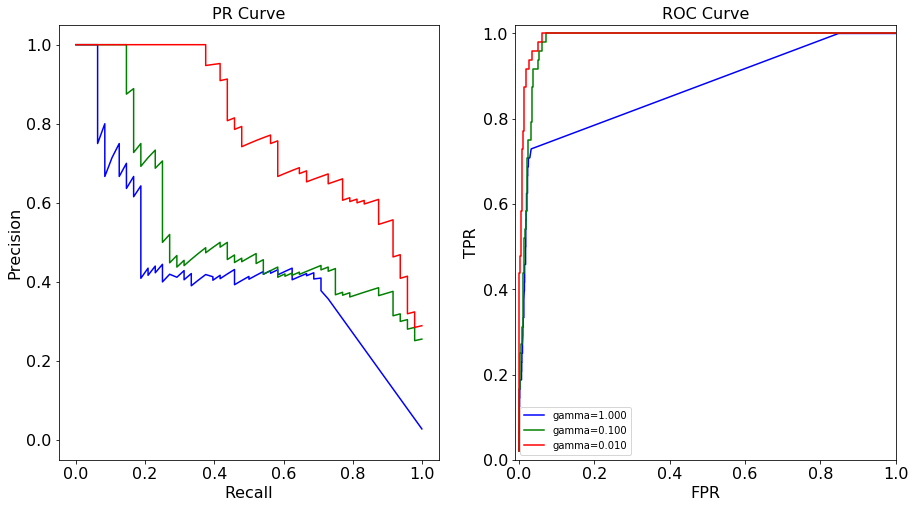

In [108]:
from sklearn.metrics import roc_curve
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for gamma, k in zip([1, 0.1, 0.01], 'bgrcmykw'): #, 1, 0.1, 0.01
    svc = SVC(gamma=gamma, probability=True).fit(X_train_selected, y_train_sampled)
    accuracy = svc.score(X_test_selected, y_test)
    auc = roc_auc_score(le.transform(y_test), svc.decision_function(X_test_selected)) #le.transform(svc.predict(X_test_selected)))#
    fpr, tpr, thresholds = roc_curve(le.transform(y_test), svc.decision_function(X_test_selected))
#     close_zero = np.argmin(np.abs(thresholds-0.7))
#     plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
#          label="threshold zero SVC", fillstyle="none", c='k', mew=2)
#    print("n_estimators = {:.0f}  accuracy = {:.3f}  AUC = {:.3f}".format(
#            n_estimators, accuracy, auc))
#    print(thres, np.abs(thres - 0.5))

#     plt.plot(fpr, tpr, label="gamma={:.3f}".format(gamma))
    p,r,_ = precision_recall_curve(le.transform(y_test), svc.decision_function(X_test_selected))
    print("gamma = {:.3f}  accuracy = {:.3f}  AUC = {:.3f}".format(
            gamma, accuracy, auc))
    print(classification_report(y_test, svc.predict(X_test_selected)))
    ax1.plot(r,p,c=k,label="gamma={:.3f}".format(gamma))
    ax2.plot(fpr, tpr, c=k,label="gamma={:.3f}".format(gamma))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc="best")

n_estimators = 1.000  accuracy = 0.969  AUC = 0.953
             precision    recall  f1-score   support

      False       1.00      0.97      0.98      1952
       True       0.43      0.94      0.59        48

avg / total       0.98      0.97      0.97      2000

n_estimators = 2.000  accuracy = 0.996  AUC = 0.987
             precision    recall  f1-score   support

      False       1.00      1.00      1.00      1952
       True       0.93      0.90      0.91        48

avg / total       1.00      1.00      1.00      2000

n_estimators = 10.000  accuracy = 0.999  AUC = 1.000
             precision    recall  f1-score   support

      False       1.00      1.00      1.00      1952
       True       0.96      1.00      0.98        48

avg / total       1.00      1.00      1.00      2000



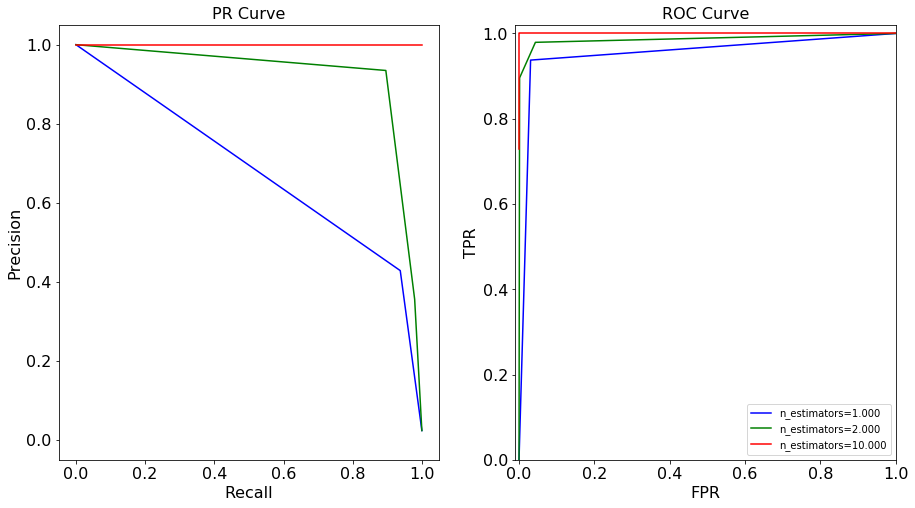

In [115]:
from sklearn.metrics import roc_curve
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for n_estimators, k in zip([1, 2, 10], 'bgrcmykw'):
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=0).fit(X_train_selected, y_train_sampled)
    accuracy = rf.score(X_test_selected, y_test)
    auc = roc_auc_score(le.transform(y_test), rf.predict_proba(X_test_selected)[:, 1])
    fpr, tpr, thresholds = roc_curve(le.transform(y_test), rf.predict_proba(X_test_selected)[:, 1])
#     close_zero = np.argmin(np.abs(thresholds-0.7))
#     plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
#          label="threshold zero SVC", fillstyle="none", c='k', mew=2)
#    print("n_estimators = {:.0f}  accuracy = {:.3f}  AUC = {:.3f}".format(
#            n_estimators, accuracy, auc))
#    print(thres, np.abs(thres - 0.5))

#     plt.plot(fpr, tpr, label="gamma={:.3f}".format(gamma))
    p,r,_ = precision_recall_curve(le.transform(y_test), rf.predict_proba(X_test_selected)[:, 1])
    print("n_estimators = {:.3f}  accuracy = {:.3f}  AUC = {:.3f}".format(
            n_estimators, accuracy, auc))
    print(classification_report(y_test, rf.predict(X_test_selected)))
    ax1.plot(r,p,c=k,label="n_estimators={:.3f}".format(n_estimators))
    ax2.plot(fpr, tpr, c=k,label="n_estimators={:.3f}".format(n_estimators))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc="best")

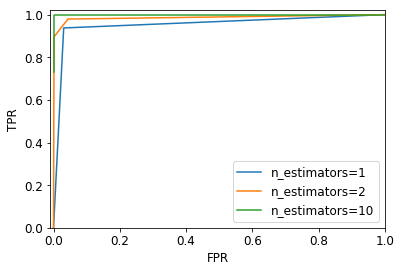

In [93]:
for n_estimators in [1, 2, 10]:
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=0).fit(X_train_selected, y_train_sampled)
    accuracy = rf.score(X_test_selected, y_test)
    auc = roc_auc_score(le.transform(y_test), rf.predict_proba(X_test_selected)[:, 1])
    fpr, tpr, thres = roc_curve(le.transform(y_test), rf.predict_proba(X_test_selected)[:, 1])
    plt.plot(fpr, tpr, label="n_estimators={:.0f}".format(n_estimators))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc="best")

In [ ]:
plot_roc(*roc_data, label_every=5)

In [86]:
rf_1, cv_score_rf_1, test_score_rf_1 = classification(RandomForestClassifier(n_estimators=1, random_state=0))
rf_2, cv_score_rf_2, test_score_rf_2 = classification(RandomForestClassifier(n_estimators=2, random_state=0))
rf_3, cv_score_rf_3, test_score_rf_3 = classification(RandomForestClassifier(n_estimators=10, random_state=0))

Classifier parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)>
Cross-validation accuracy: 0.942
Test score: 0.969
Classifier parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)>
Cross-v

In [ ]:
clf = pipeline.Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(C=1000, gamma=0.1, kernel='linear', probability=True))])
pipe_test, cv_score_test, test_score_test = classification(clf)

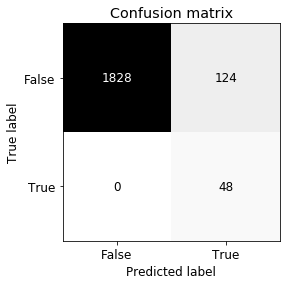

In [86]:
target_names = np.array(le.classes_)
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test, svm_4.predict(X_test_selected)), xlabel='Predicted label',
    ylabel='True label', xticklabels=target_names,
    yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

### SHAP explaining predictions after under-sampling

In [88]:
def shap_explain(X_train_selected, X_test_selected, clf, samples):
    explainer = shap.KernelExplainer(clf.predict_proba, X_train_selected)
    shap_values = explainer.shap_values(X_test_selected.loc[samples.index])
    return shap_values

In [89]:
samples_true = y_test[le.transform(y_test)==1]
samples = y_test.sample(samples_true.count(), random_state=0)
samples_all = pd.concat((pd.DataFrame(samples_true), pd.DataFrame(samples)))

In [90]:
shap_values_rf_1 = shap_explain(X_train_selected, X_test_selected, rf_1, samples_all)

100%|██████████| 96/96 [21:10<00:00, 13.24s/it]


In [91]:
shap_values_rf_2 = shap_explain(X_train_selected, X_test_selected, rf_2, samples_all)

100%|██████████| 96/96 [22:56<00:00, 14.34s/it]


In [92]:
shap_values_rf_3 = shap_explain(X_train_selected, X_test_selected, rf_3, samples_all)

100%|██████████| 96/96 [26:19<00:00, 16.45s/it]


In [93]:
shap_values_svm_1 = shap_explain(X_train_selected, X_test_selected, svm_1, samples_all)

100%|██████████| 96/96 [35:46<00:00, 22.36s/it]


In [94]:
shap_values_svm_2 = shap_explain(X_train_selected, X_test_selected, svm_2, samples_all)

100%|██████████| 96/96 [38:20<00:00, 23.96s/it]


In [95]:
shap_values_svm_3 = shap_explain(X_train_selected, X_test_selected, svm_3, samples_all)

100%|██████████| 96/96 [38:12<00:00, 23.88s/it]


In [96]:
shap_values_svm_4 = shap_explain(X_train_selected, X_test_selected, svm_4, samples_all)

100%|██████████| 96/96 [31:35<00:00, 19.74s/it]


In [229]:
shap.initjs()

In [153]:
i = 12
shap.force_plot(shap_values_rf_3[1][i], X_test_selected.loc[samples_all.index].iloc[i, :])
# print(svm_3.predict_proba([X_test_selected.loc[samples_all.index].iloc[i, :]]))

In [97]:
shap.force_plot(shap_values_svm_1[1], X_test_selected.loc[samples_all.index])

In [98]:
shap.force_plot(shap_values_svm_2[1], X_test_selected.loc[samples_all.index])

In [99]:
shap.force_plot(shap_values_svm_3[1], X_test_selected.loc[samples_all.index])

In [135]:
rf_3.predict_proba(X_test_selected.loc[samples_all.index])

array([[ 0.1,  0.9],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0.1,  0.9],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0.1,  0.9],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0.1,  0.9],
       [ 0.2,  0.8],
       [ 0. ,  1. ],
       [ 0.1,  0.9],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0.1,  0.9],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0.1,  0.9],
       [ 0.1,  0.9],
       [ 0.1,  0.9],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0.1,  0.9],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0.1,  0.9],
       [ 0. ,  1. ],
       [ 0. ,  1. ],
       [ 0.2,  0.8],
       [ 0. ,

In [51]:
shap.force_plot(shap_values_svm_4[1], X_test_selected.loc[samples_all.index])

In [132]:
shap.force_plot(shap_values_rf_1[1], X_test_selected.loc[samples_all.index])

In [133]:
shap.force_plot(shap_values_rf_2[1], X_test_selected.loc[samples_all.index])

In [134]:
shap.force_plot(shap_values_rf_3[1], X_test_selected.loc[samples_all.index])

### SHAP explanation of SVM with Random undersampling

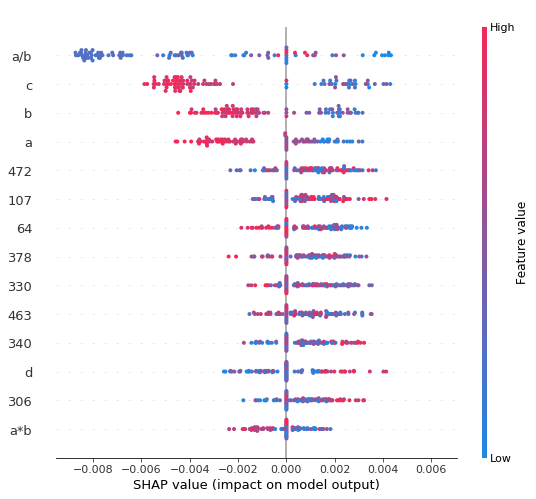

In [41]:
shap.summary_plot(shap_values_svm_1[1], X_test_selected.loc[samples_all.index])

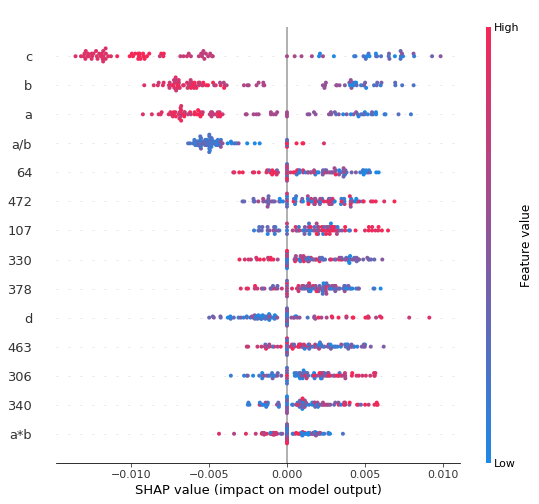

In [109]:
shap.summary_plot(shap_values_svm_2[1], X_test_selected.loc[samples_all.index])

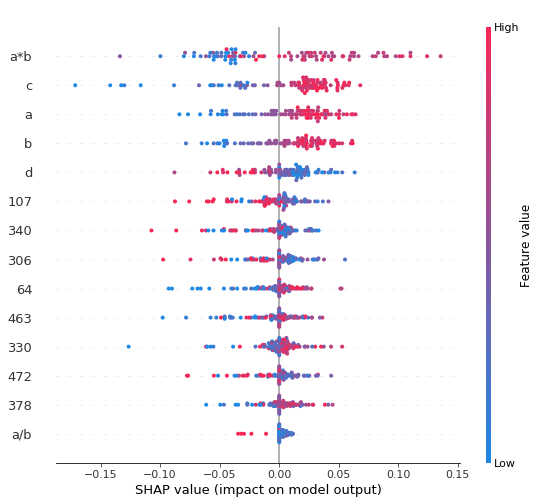

In [110]:
shap.summary_plot(shap_values_svm_3[1], X_test_selected.loc[samples_all.index])

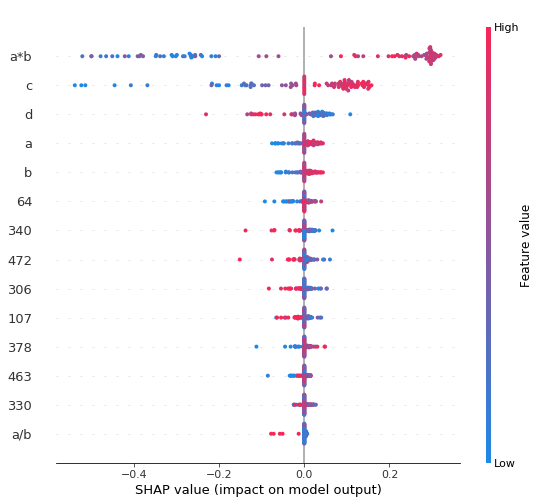

In [111]:
shap.summary_plot(shap_values_svm_4[1], X_test_selected.loc[samples_all.index])

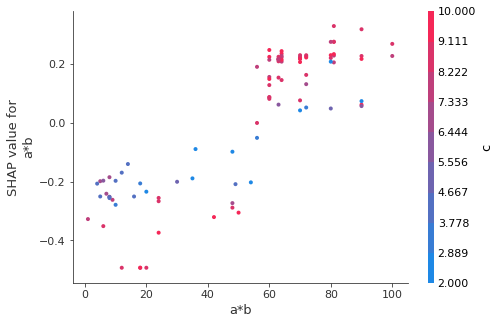

In [124]:
shap.dependence_plot("a*b", shap_values_rf_2[1], X_test_selected.loc[samples_all.index])

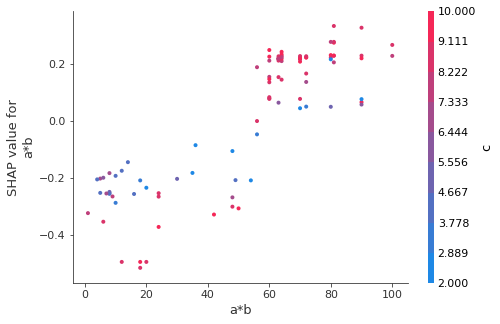

In [453]:
shap.dependence_plot("a*b", shap_values_rf_2[1], X_test_selected.loc[samples_all.index])

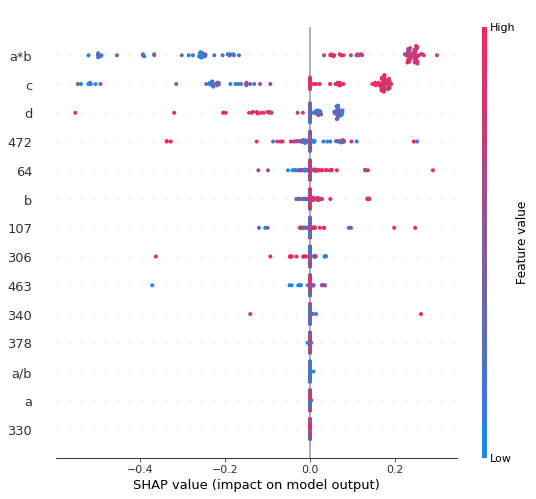

In [45]:
shap.summary_plot(shap_values_rf_1[1], X_test_selected.loc[samples_all.index])

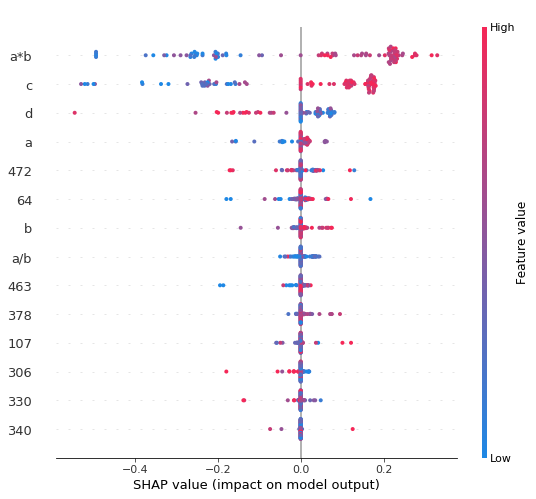

In [46]:
shap.summary_plot(shap_values_rf_2[1], X_test_selected.loc[samples_all.index])

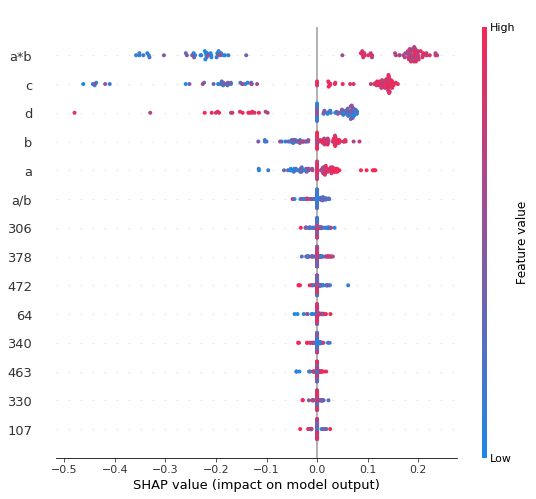

In [47]:
shap.summary_plot(shap_values_rf_3[1], X_test_selected.loc[samples_all.index])

### SHAP explanation of Random Forests with Random undersampling

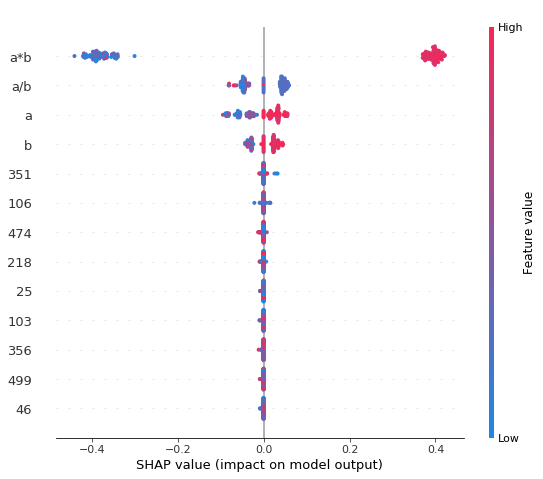

In [245]:
shap.summary_plot(shap_values_rf[1], pd.DataFrame(X_test_selected))

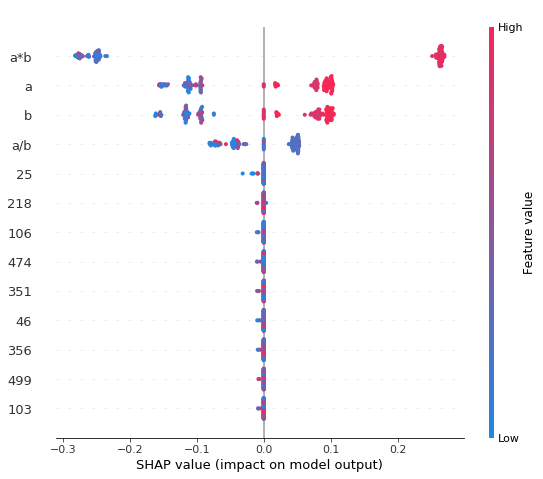

In [213]:
shap.summary_plot(shap_values_rf_500[1], pd.DataFrame(X_test_selected))

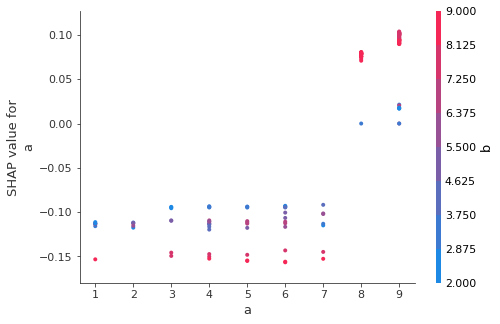

In [267]:
shap.dependence_plot("a", shap_values_rf_500[1], X_test_selected)

### SHAP explaining predictions of XGBoost

In [136]:
xgb_train = xgboost.DMatrix(X_train_selected, label=le.transform(y_train_sampled))
xgb_test = xgboost.DMatrix(X_test_selected, label=le.transform(y_test))
xgb_samples = xgboost.DMatrix(X_test_selected.loc[samples_all.index], label=le.transform(y_test[samples_all.index]))

In [137]:
# use validation set to choose # of trees
params = {'max_depth':20, 'n_estimators':1,
         'objective': 'multi:softmax', 'num_class': 2
}

xgb = xgboost.train(params, xgb_train, 100)

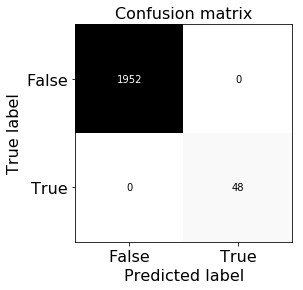

In [138]:
target_names = np.array(le.classes_)
scores_image = mglearn.tools.heatmap(
    confusion_matrix(le.transform(y_test), xgb.predict(xgb_test)), xlabel='Predicted label',
    ylabel='True label', xticklabels=target_names,
    yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

In [139]:
shap_values_xgb = xgb.predict(xgb_test, pred_contribs=True)

In [140]:
shap_values_xgb_samples = xgb.predict(xgb_samples, pred_contribs=True)

In [147]:
sum(xgb.predict(xgb_samples, pred_contribs=True)[1][1])

3.5720914397388697

In [141]:
shap.force_plot(shap_values_xgb_samples[:, 1, :], X_test_selected.loc[samples_all.index])

In [60]:
shap.force_plot(shap_values_xgb[:, 1, :], X_test_selected)

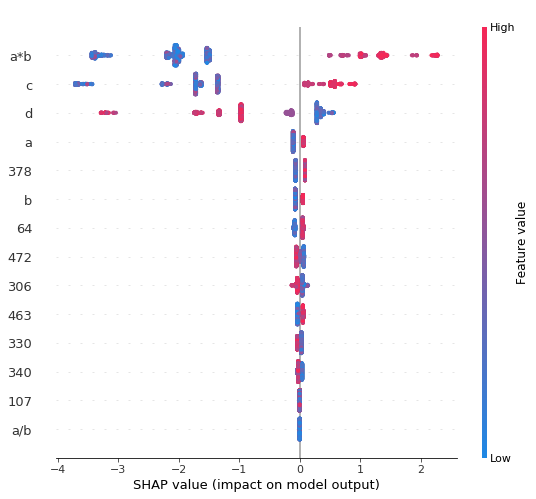

In [61]:
shap.summary_plot(shap_values_xgb[:, 1, :], X_test_selected)

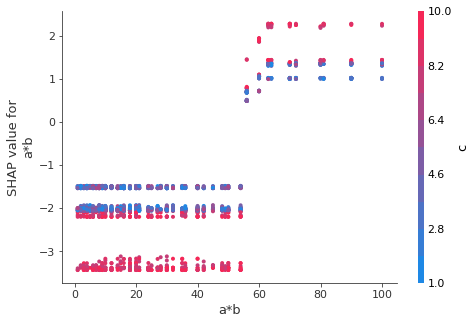

In [62]:
shap.dependence_plot("a*b", shap_values_xgb[:, 1, :], X_test_selected)

In [260]:
shap_interaction_values = xgb.predict(xgb_test, pred_interactions=True)

In [261]:
X_test_selected.columns = X_test_selected.columns.astype(str)

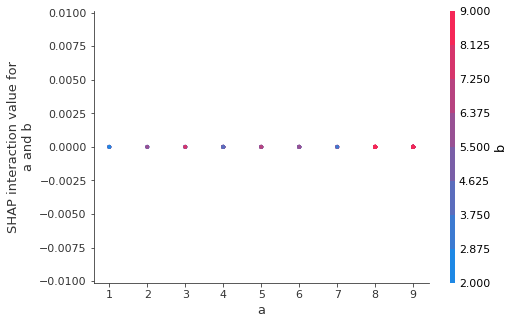

In [204]:
shap.dependence_plot(
    ("a", "b"),
    shap_interaction_values[:, 1, :, :], X_test_selected,
    display_features=X_test_selected
)

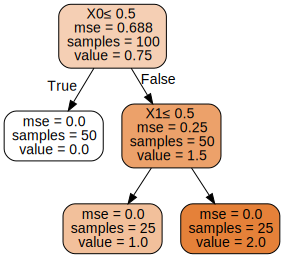

In [5]:
# build data
N = 100
M = 4
X = np.zeros((N,M))
X.shape
y = np.zeros(N)
X[:N//2, 0] = 1
X[:1 * N//4, 1] = 1
X[N//2:3 * N//4, 1] = 1
y[:1 * N//4] = 1
y[:N//2] += 1

# fit model
and_fb_model = sklearn.tree.DecisionTreeRegressor(max_depth=2)
and_fb_model.fit(X, y)

# draw model
dot_data = sklearn.tree.export_graphviz(and_fb_model, out_file=None, filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

In [8]:
xs = [np.ones(M), np.zeros(M)]
for x in xs:
    print()
    print("          x =", x)
    print("shap_values =", shap.TreeExplainer(and_fb_model).shap_values(x))


          x = [ 1.  1.  1.  1.]
shap_values = [ 0.875  0.375  0.     0.     0.75 ]

          x = [ 0.  0.  0.  0.]
shap_values = [-0.625 -0.125  0.     0.     0.75 ]
